- analisi dataset
    - analisi features
        - scelta delle sole immagini e scarto delle features nel csv
    - analisi immagini
        - stats() nel dataset
        - print istogrammi delle label
- pre-processing
    - data augmentation
        - obiettivo di 6000 immagini per label
        - arricchimento dataframe
    - image rescaling (600x450 => 200x150)
    - split in train/test/validation

In [ ]:
# imports
import os
import cv2
import sklearn.preprocessing as preproc
import numpy as np
import keras as k
#import matplotlib.pyplot as plt
#from time import time
import pandas as pd
import tensorflow as tf
from PIL import Image
import math
import shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

In [ ]:
# dichiarazione funzioni

# codifica la colonna dx da originale (stringhe) a label encoding (0,1,..,6)
def lab_encode(dataset, le):
    new_ds = dataset
    new_ds["dx"] = le.fit_transform(dataset["dx"])  
    return new_ds


# decodifica colonna dx
def lab_decode(dataset, le):
    new_ds = dataset
    new_ds["dx"] = le.inverse_transform(dataset["dx"])  
    return new_ds


# conteggio immagini da generare dal dataset, risultato salvato in aug_size
def stats(dataset, aug_size):
    labels = set(dataset['dx'])
    for label in labels:
        print("class ", str(label), ':\t', str(dataset[dataset['dx']==label]['dx'].count()))
        x = dataset[dataset['dx']==label]['dx'].count()
        y = dataset[dataset['dx']==5]['dx'].count()
        value = math.floor((y-x)/x)
        print("ugmented per image: ", str(value), "\n")
        aug_size[label] = value
        
        
# apre il dataset originale, toglie le features superflue e lo ritorna insieme all'array delle labels
def initialize_dataset():
    dataset = pd.read_csv(csv_path, encoding = "ISO-8859-1")
    labels = set(dataset["dx"])
    new_ds = pd.DataFrame(dataset)
    columns=["lesion_id", "dx_type", "age", "sex", "localization"]
    new_ds = new_ds.drop(columns=columns, axis=0)
    return new_ds, labels


# dall'array di nomi (es. dataset["image_id"]) ritorna l'array d'immagini
def load_images(array):
    images = list()
    #print(array.iloc[0])
    for index in range(0,len(array)):
        #print(index.type())
        img_id = array.iloc[index]
        elem = os.path.join(image_path, img_id)
        elem = elem + ".jpg"
        img = cv2.imread(elem)
        images.append(np.asarray(img))
    return np.asarray(images)


#  ritorna la parte di dataset che nel nome contiene il nome delle tuple di originale (originale è un dataset senza immagini aumentate)
# (usato solo dopo aver partizionato originale, per avere iol training set anche con immagini aumentate)
def estendi(dataset, originale):
    res = pd.DataFrame()
    for index2 in range(len(originale)):
        temp = dataset[dataset["image_id"].str.contains(originale.iloc[index2]["image_id"])]
        res = res.append(temp)
        if index2 % 1000 == 0:
            print(index2)
    return res


# ritorna le 2 partizioni del dataframe (che non deve essere esteso) di fattori factor e 1-factor
# es. factor = 0.8
def partiziona(dataframe, factor):
    part1 = pd.DataFrame()  # factor originali
    part2 = pd.DataFrame()  # (1-factor) originali
    for elem in range(7):
        n = dataframe[dataframe['dx']==elem]['dx'].count() 
        p8 = int(n*factor)
        print("n di tipo ", elem, ":\t", n, "\tandranno in part1:\t", p8)
        blocco = dataframe[dataframe['dx']==elem]
        blocco1 = blocco.sample(n=p8)
        part1 = part1.append(blocco1)
        part2 = part2.append(blocco.drop(blocco1.index))
    print("size part1: ", len(part1))
    print("size part2: ", len(part2))
    return part1, part2


# recupero dataset originale (senza immagini aumentate) dal dataset completo
def only_orig(dataset):
    reduced = pd.DataFrame()
    for index in range(len(dataset)):
        if len(dataset.iloc[index]["image_id"]) == 12:
            reduced = reduced.append(dataset.iloc[index])
    return reduced

# a seconda della direzione sposta le immagini dentro oppure fuori le cartelle classi (0,...,6) partendo dalla loro madre
# usato in fase di data augmentation per mettere/togliere le immmagini nella cartella label
# cartella = orig_dir
def dir_game(dataset, cartella, out=0):
    for index in range(len(dataset)):
        img=dataset.iloc[index]["image_id"]
        source = os.path.join(cartella, img) # source/image
        source = source +'.jpg'              # source/image.jpg
        dx =str(dataset.iloc[index]["dx"])
        dest = os.path.join(cartella, dx)    # source/label
        dest = os.path.join(dest, img)       # source/label/image
        dest = dest + '.jpg'                 # source/label/image.jpg
        if out == 0:
            os.replace(source, dest)         # metto le immagini dentro le cartelle classi
        elif out == 1:
            os.replace(dest, source)         # metto le immagini fuori le cartelle classi
        else:
            print("input error")
            break
    return

# rescaling immagini, src e dst sono cartelle contenenti immagini
def rescale(src_path, dst_path, size=(200,150)):
    count = 0
    for fname in os.listdir(src_path):
        if len(fname) < 2:                      # non è un immagine ma una cartella label
            continue
        img_rsz = Image.open(os.path.join(src_path, fname)).resize(size)
        img_rsz.save(os.path.join(dst_path, fname))
        count = count + 1
        if count % 5000 == 0:
            print("rescaled " + str(count) + " images")
    return

In [ ]:
# variabili globali
image_path = '..\\images'
aug_dir = '..\\images\\augmented'                 # path delle immagini aumentate
orig_dir = '..\\images\\original'                 # path delle immagini originali
res_dir = '..\\images\\rescaled'                  # path delle immagini riscalate

csv_path = '..\\csv\\HAM10000_metadata.csv'       # csv originale
csv_enc = '..\\csv\\csv_encoded.csv'              # originale ripulito e codificato
csv_completo = '..\\csv\\dataframe_completo.csv'  # csv completo
csv_aug = '..\\csv\\augmented_only.csv'           # csv con sole immagini aumentate

In [ ]:
# INIZIALIZZAZIONE

#creazione dataframe in memoria con colonne [image_id, dx]
ds, labels = initialize_dataset()


# label encoding delle labels (dx)
encoder = preproc.LabelEncoder()
encoded = lab_encode(ds, encoder)
encoded = encoded.sort_index()

encoded.to_csv(csv_enc, index=False)
encoded

,image_id,dx
0,ISIC_0027419,2
1,ISIC_0025030,2
2,ISIC_0026769,2
3,ISIC_0025661,2
4,ISIC_0031633,2
5,ISIC_0027850,2
6,ISIC_0029176,2
7,ISIC_0029068,2
8,ISIC_0025837,2
9,ISIC_0025209,2


<BarContainer object of 7 artists>

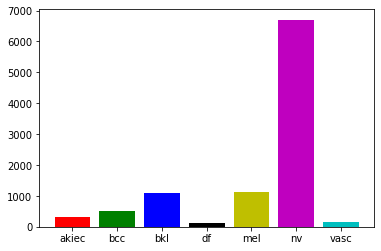

In [ ]:
# istogramma prima del data augmentation
data = {'dx':  ['akiec','bcc','bkl','df','mel','nv','vasc'],
    'val':  [len(encoded[encoded['dx']==0].index),
        len(encoded[encoded['dx']==1].index),
        len(encoded[encoded['dx']==2].index),
        len(encoded[encoded['dx']==3].index),
        len(encoded[encoded['dx']==4].index),
        len(encoded[encoded['dx']==5].index),
        len(encoded[encoded['dx']==6].index)]}

histo = pd.DataFrame(data, columns = ['dx','val'])
plt.bar(x=histo['dx'],height=histo['val'],color='rgbkymc')

In [ ]:
# analisi dei valori per data augmentation
aug_size = [0,0,0,0,0,0,0]
stats(encoded, aug_size)

class  0 :	 327
ugmented per image:  19 

class  1 :	 514
ugmented per image:  12 

class  2 :	 1099
ugmented per image:  5 

class  3 :	 115
ugmented per image:  57 

class  4 :	 1113
ugmented per image:  5 

class  5 :	 6705
ugmented per image:  0 

class  6 :	 142
ugmented per image:  46 



In [ ]:
# predisposizione cartelle
for elem in range(7):
    new = os.path.join(orig_dir, str(elem))
    os.mkdir(new)   # cartelle da 0 a 6 dentro ../images/original/

# metto le immagini originali nelle specifiche cartelle label
dir_game(dataset=encoded, out=0, cartella=orig_dir)

In [ ]:
# DATA AUGMENTATION

# Create a data generator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    #brightness_range=(0.9,1.1),
    fill_mode='nearest')

##### creazione immagini augmented
# non aumentiamo la classe 'nv', cioè la 5
class_list = ['0','1','2','3','4','6']


for img_class in class_list:    
    # creazione cartelle contenenti le augmented
    dst_class_dir = os.path.join(aug_dir, img_class)
    os.mkdir(dst_class_dir)   # cartelle da 0 a 6 dentro ../images/augmented
    
    # listing immagini nelle cartelle label originali, cioè ../images/original/label/
    src_class_dir = os.path.join(orig_dir, img_class)
    img_list = os.listdir(src_class_dir) # qui le immagini sono già nelle proprie cartelle, cioè in ../images/original/label
    print('#img: '+ str(len(img_list)))
    
    # per ogni immagine devo creare le augmented
    for fname in img_list:
        fpath = os.path.join(src_class_dir, fname) # path completo dell'immagine src
        img = Image.open(fpath)                    # PIL image
        x = img_to_array(img)                      # this is a Numpy array with shape (3, 600, 450)
        x = x.reshape((1,) + x.shape)              # this is a Numpy array with shape (1, 3, 600, 450)
        
        prefix = fname.replace(".jpg", "")         # prefisso delle nuove img, cioè il nome dell'originale
        # the .flow() command below generates batches of randomly transformed images 
        # lo faccio fino a quando non arrivo all'aug_size
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=dst_class_dir, save_prefix=prefix , save_format='jpg'):
            i += 1
            if i > aug_size[int(img_class)]:
                break
        del x
        img.close()

#img: 327
#img: 514
#img: 1099
#img: 115
#img: 1113
#img: 142


In [ ]:
############## aggiornamento nuovo dataset con le immagini aumentate
img_dir = os.path.join(aug_dir, 'img_dir') 
classes = os.listdir(aug_dir)                  # elenco delle cartelle (da 0 a 6)

columns = encoded.columns
augmented = pd.DataFrame(columns=columns)      # dataset vuoto, alla fine dei cicli for conterrà tutte le nuove immagini aumentate con dx cartella madre

for elem1 in classes:
    class_dir = os.path.join(aug_dir, elem1)
    images = os.listdir(class_dir)
    for elem2 in images:
        elem2 = elem2.replace('.jpg', '')
        augmented = augmented.append({'image_id': elem2, 'dx': int(elem1)}, ignore_index=True)
        
encoded2 = encoded.append(augmented)
encoded2.to_csv(csv_completo, index=False)
augmented.to_csv(csv_aug, index=False)

<BarContainer object of 7 artists>

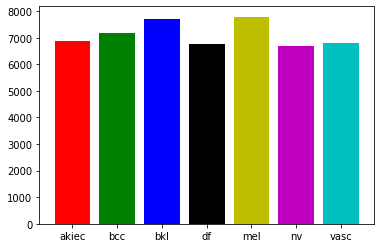

In [ ]:
# istogramma dopo data augmentation
dataset = pd.read_csv(csv_completo, encoding = "ISO-8859-1")
data = {'dx':  ['akiec','bcc','bkl','df','mel','nv','vasc'],
    'val':  [len(dataset[dataset['dx']==0].index),
        len(dataset[dataset['dx']==1].index),
        len(dataset[dataset['dx']==2].index),
        len(dataset[dataset['dx']==3].index),
        len(dataset[dataset['dx']==4].index),
        len(dataset[dataset['dx']==5].index),
        len(dataset[dataset['dx']==6].index)]}

histo = pd.DataFrame(data, columns = ['dx','val'])
plt.bar(x=histo['dx'],height=histo['val'],color='rgbkymc')

In [ ]:
# RESCALING

# porto le immagini al di fuori delle cartelle label, sia in original che in augmented
dir_game(encoded, orig_dir, out=1)
dir_game(augmented, aug_dir, out=1)

# applico il rescaling nelle immagini e salvo tutto in rescaled
rescale(src_path=orig_dir, dst_path=res_dir)
rescale(src_path=aug_dir, dst_path=res_dir)

rescaled 5000 images
rescaled 10000 images
rescaled 5000 images
rescaled 10000 images
rescaled 15000 images
rescaled 20000 images
rescaled 25000 images
rescaled 30000 images
rescaled 35000 images


In [ ]:
# creazione nuovi dataset con train set aumentato, e test e validation con dimensioni a scelta

dataset = pd.read_csv(csv_completo, encoding = "ISO-8859-1")
originale = pd.read_csv(csv_enc, encoding = "ISO-8859-1")

# split di "originale" 80 20 (il 20 sarà il test)
orig_08, orig_02 = partiziona(originale, 0.8)

#orig_08.to_csv('..\\csv\\orig_08.csv', index=False)
orig_02.to_csv('..\\csv\\train_test_val\\test_orig_02.csv', index=False)

n di tipo  0 :	 327 	andranno in part1:	 261
n di tipo  1 :	 514 	andranno in part1:	 411
n di tipo  2 :	 1099 	andranno in part1:	 879
n di tipo  3 :	 115 	andranno in part1:	 92
n di tipo  4 :	 1113 	andranno in part1:	 890
n di tipo  5 :	 6705 	andranno in part1:	 5364
n di tipo  6 :	 142 	andranno in part1:	 113
size part1:  8010
size part2:  2005


In [ ]:
# split di "orig_08" 80 20 (80 train 20 validation)
orig_064, orig_016 = partiziona(orig_08, 0.8)

#orig_064.to_csv('..\\csv\\train_test_val\\orig_064.csv', index=False)
orig_016.to_csv('..\\csv\\train_test_val\\val_orig_016.csv', index=False)

n di tipo  0 :	 261 	andranno in part1:	 208
n di tipo  1 :	 411 	andranno in part1:	 328
n di tipo  2 :	 879 	andranno in part1:	 703
n di tipo  3 :	 92 	andranno in part1:	 73
n di tipo  4 :	 890 	andranno in part1:	 712
n di tipo  5 :	 5364 	andranno in part1:	 4291
n di tipo  6 :	 113 	andranno in part1:	 90
size part1:  6405
size part2:  1605


In [ ]:
# dalla partizione del datset originale (orig_X) faccio la partizione del dataset esteso (esteso_X)
esteso_064 = estendi(dataset, orig_064)

esteso_064.to_csv('..\\csv\\train_test_val\\train_esteso_064.csv', index=False)

0
1000
2000
3000
4000
5000
6000
